# Climate Analysis

Using Python and SQLAlchemy again, basic climate analysis and data exploration will be completed within this notebook. Tools used will be ORM queries via SQLAlchemy, Matplotlib, and Pandas. 

Analysis will be performed on precipitation, temperature, and stations.

In [173]:
# Import dependencies
import datetime as dt
import numpy as np
import pandas as pd

import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, desc
from sqlalchemy.sql import label

from flask import Flask, jsonify

import matplotlib.pyplot as plt

### Setting up and reflecting the existing sqlite database

In [77]:
# Database setup
engine = create_engine("sqlite:///hawaii.sqlite")

In [78]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [79]:
# Save reference to the tables
Measurement = Base.classes.measurements
Stations = Base.classes.stations

In [80]:
# Create our session (link) from Python to the DB
session = Session(bind = engine)

#### Exploring the database

In [81]:
# Getting the table names for each table
inspector = inspect(engine)
inspector.get_table_names()

['measurements', 'stations']

In [82]:
# Get a list of column names and types - measurements
columns = inspector.get_columns('measurements')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date DATE
precip FLOAT
tobs FLOAT


In [83]:
# Get a list of column names and types - stations
columns = inspector.get_columns('stations')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [84]:
engine.execute('SELECT * FROM stations LIMIT 5').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

In [85]:
engine.execute('SELECT * FROM measurements LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', None, 65.0),
 (2, 'USC00519397', '2010-01-02', None, 63.0),
 (3, 'USC00519397', '2010-01-03', None, 74.0),
 (4, 'USC00519397', '2010-01-04', None, 76.0),
 (5, 'USC00519397', '2010-01-07', None, 70.0)]

### Climate Analysis: precipitation

In [65]:
# Select prcp & date for the last 12 months
results = session.query(Measurement.date, Measurement.precip).filter(Measurement.date >= '2017-01-01')

In [74]:
# create empty dict to populate
data = {'date': [], 'precip': []}

# populate dict with rows from results
for row in results:
    data['date'].append(row.date)
    data['precip'].append(row.precip)

# create pandas df from dict
precip17 = pd.DataFrame(data['precip'], columns = ['prcp'], index = data['date'])
print(prcp17.head())

Empty DataFrame
Columns: [precipitation]
Index: []


In [88]:
precip17.head()

,prcp
2017-01-01,None
2017-01-02,None
2017-01-03,None
2017-01-04,None
2017-01-05,None


In [ ]:
# Plot the results using the DataFrame `plot` method.

In [89]:
# Use Pandas to print the summary statistics for the precipitation data.

### Climate Analysis: temperature

In [87]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates

#Use the `calc_temps` function to calculate the min, avg, and max temperatures for your trip using the 
#matching dates from the previous year (i.e. use "2017-01-01" if your trip start date was "2018-01-01")

def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2017-02-28', '2017-03-05'))

[(64.0, 72.0, 78.0)]


In [ ]:
# Plot the min, avg, and max temperature from your previous query as a bar chart.
# Use the average temperature as the bar height.
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr).

In [121]:
temperatures = (calc_temps('2017-02-28', '2017-03-05'))
labels = ['TMIN', 'TAVE', 'TMAX']
df = pd.DataFrame.from_records(temperatures, columns=labels)


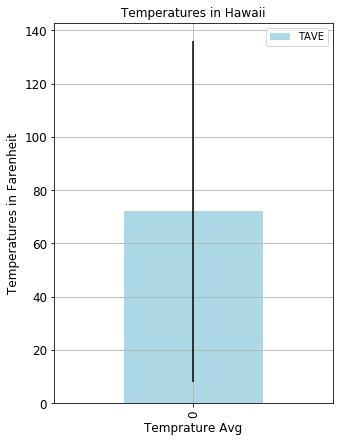

In [122]:

temp_chart = df[['TAVE']].plot(kind='bar', yerr = errors, title ="Temperatures in Hawaii", figsize=(5, 7), legend=True, fontsize=12, grid=True, color='lightblue')
temp_chart.set_xlabel("Temprature Avg", fontsize=12)
temp_chart.set_ylabel("Temperatures in Farenheit", fontsize=12)
plt.show()

### Climate Analysis: stations

In [45]:
# Total number of stations
### Which station has highest number of observations
# Retrieve last 12 months of temp obs data (tobs)
### Filter by station with highest number of observations
### Plot results as histogram with bins=12

In [145]:
# Total number of stations
stations_results = session.query(func.count(Stations.station)).all()
print("There are " + str(stations_results[0]) + " stations.")

There are (9,) stations.


In [152]:
# Most active stations
active_results = session.query(Measurement.station,
    label('date', func.count(Measurement.date))).group_by(Measurement.station).all()
for result in active_results:
    print(result)

('USC00511918', 1932)
('USC00513117', 2696)
('USC00514830', 1937)
('USC00516128', 2484)
('USC00517948', 683)
('USC00518838', 342)
('USC00519281', 2772)
('USC00519397', 2685)
('USC00519523', 2572)


In [183]:
### List stations and obs counts in descending order
desc_order = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc())
for result in desc_order:
    print(result)

('USC00519281', 2772)
('USC00513117', 2696)
('USC00519397', 2685)
('USC00519523', 2572)
('USC00516128', 2484)
('USC00514830', 1937)
('USC00511918', 1932)
('USC00517948', 683)
('USC00518838', 342)


In [184]:
### Which station has highest number of observations
obsv_num = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).first()
for result in desc_order:
    print(result)

('USC00519281', 2772)
('USC00513117', 2696)
('USC00519397', 2685)
('USC00519523', 2572)
('USC00516128', 2484)
('USC00514830', 1937)
('USC00511918', 1932)
('USC00517948', 683)
('USC00518838', 342)


In [44]:
# Flask Setup
app = Flask(__name__)